<a href="https://colab.research.google.com/github/samrudh18/Reinforcement-Learning/blob/main/CS698R-MidSem-Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import pandas as pd

## Random Maze Environment (RME)

In [ ]:
import gym
from gym import spaces
import numpy as np

class RME(gym.Env):

  def __init__(self):
    self.observation_space = spaces.Discrete(12)  #Twelve possible states
    self.action_space = spaces.Discrete(4)        #Four possible actions (up,down,left,right)
    self.state=8
    self.reward=None

  def step(self, orig_action):
    
    orig_state=self.state
    done = False

    val=np.random.uniform()
    if val<=0.8:
      action_idx=0 #take standard action
    elif 0.9>=val>0.8:
      action_idx=1 #take alt-action 1
    else:
      action_idx=2#take alt-action 2

    if orig_action==0 or orig_action==1:  #going up or down
      action= [orig_action,2,3][action_idx]
    elif orig_action==2 or orig_action==3:  #going left or right
      action= [orig_action,0,1][action_idx]
      
    self.action=action
    if action==0:  #going up
      if self.state not in [0,1,2,3]: #out of bounds
        self.state+= -4
    if action==1:  #going down
      if self.state not in [8,9,10,11]: #out of bounds
        self.state+= 4
    if action==2:  #going left
      if self.state not in [0,4,8]: #out of bounds
        self.state+= -1
    if action==3:  #going right
      if self.state not in [3,7,11]: #out of bounds
        self.state+= 1

    if self.state==5:  #hit wall
      self.state=orig_state

    if self.state==3:  
      self.reward=1      # reached the goal
      done=True          #terminal state
    elif self.state==7:
      self.reward=-1     #reached the hole
      done=True
    else:
      self.reward=-0.04  #living penalty
    
    info = {'orig':orig_action,'action':action}

    return self.state, self.reward, done, info
    
  def reset(self):
    # Reset the state of the environment to an initial state
    self.state = 8
    done=False
    return self.state,done

  def seed(self,seed=31):
    self.seed=np.random.seed(seed)

In [ ]:
env=RME()
s,done=env.reset()
env.seed()
total_rewards=[]
policies=[[0,1,2,3],[1,2],[0,3],'optimal']
opt_policy=[3,3,3,0,0,0,0,0,0,3,0,2]
for policy in policies:
  results=[]
  for _ in range(100):
    if policy=='optimal':
      a=opt_policy[s]
    else:
      a=np.random.choice(policy)
    s_, r, done, info=env.step(a)
    results.append([s,a,info['action'],s_,r,done])
    s=s_
    if done:
      s,done=env.reset()
      break
  total_rewards.append(np.sum(np.array(results)[:,-2]))

Text(0, 0.5, 'Total rewards received')

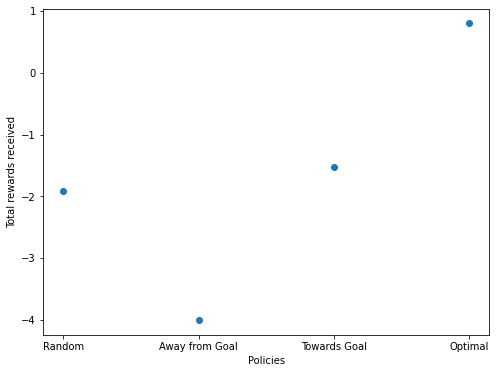

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(['Random','Away from Goal','Towards Goal','Optimal'],total_rewards,'o')
plt.xlabel('Policies')
plt.ylabel('Total rewards received')

### RME Optimal Policy via Dynamic Programming

In [ ]:
R=[-0.04]*env.observation_space.n
R[3]=1
R[7]=-1 

In [ ]:
transition_prob={}
for s in range(12): #total states
  if s in [5,3,7]:  #wall and terminal states
    continue
  for a in range(4):  #total actions
    if a==0: #up
      if s not in [0,1,2,3,9]: #out of bounds
         transition_prob[(s,a,s-4)]=0.8  #up
      if s not in [0,4,8,6]:
         transition_prob[(s,a,s-1)]=0.1  #left
      if s not in [3,7,11,4]:
         transition_prob[(s,a,s+1)]=0.1  #right
    
    elif a==1: #down
      if s not in [8,9,10,11,1]: #out of bounds
         transition_prob[(s,a,s+4)]=0.8  #down
      if s not in [0,4,8,6]:
         transition_prob[(s,a,s-1)]=0.1  #left
      if s not in [3,7,11,4]:
         transition_prob[(s,a,s+1)]=0.1  #right
    
    elif a==2: #left
      if s not in [0,4,8,6]: #out of bounds
         transition_prob[(s,a,s-1)]=0.8  #left
      if s not in [0,1,2,3,9]: #out of bounds
         transition_prob[(s,a,s-4)]=0.1  #up
      if s not in [8,9,10,11,1]: 
         transition_prob[(s,a,s+4)]=0.1  #down
  
    elif a==3: #right
      if s not in [3,7,11,4]: #out of bounds
         transition_prob[(s,a,s+1)]=0.8  #right
      if s not in [0,1,2,3,9]: #out of bounds
         transition_prob[(s,a,s-4)]=0.1  #up
      if s not in [8,9,10,11,1]: 
         transition_prob[(s,a,s+4)]=0.1  #down


In [ ]:
import copy 
def policy_eval(env,R,transition_prob,policy,maxSteps=100,gamma=0.99):
    
    n=env.observation_space.n
    V=[0]*n
    for i in range(maxSteps):
        old_V = copy.deepcopy(V)
        for s in range(n):    
            a=policy[s]
            temp = 0
            for j in range(n):
                if((s,a,j) in transition_prob):
                    temp+= transition_prob[s,a,j]*(R[j] + gamma*old_V[j])    
            V[s] = temp

        if V==old_V:
            return np.array(V)
    
    return np.array(V)

In [ ]:
def policy_improve(env,R,transition_prob,policy,V,iters=1,gamma=0.99):

    s_n=env.observation_space.n #number of states
    a_n=env.action_space.n  #number of actions
    q=np.array([[0.0]*a_n]*s_n)  #q values for (s,a) pairs
    for i in range(iters): #number of times policy is improved  
        for s in range(s_n):    
            val = np.array([0.0]*a_n)
            for a in range(a_n):
                temp = 0
                for j in range(s_n):
                    if((s,a,j) in transition_prob):
                        temp+= transition_prob[s,a,j]*(R[j] + gamma*V[j])
                q[s][a]=temp

        for s in range(len(q)):
            policy[s]=np.argmax(q[s])   #best actions
    
    return policy

In [ ]:
import copy
def PolicyIteration(env,policy):

  V=[0.0]*env.observation_space.n
  for i in range(100):
      new_policy=copy.deepcopy(policy)
      old_V = copy.deepcopy(V)
      V=policy_eval(env=env,R=R,transition_prob=transition_prob,policy=new_policy)
      policy=policy_improve(env=env,R=R,transition_prob=transition_prob,policy=new_policy,V=V)
      
      if sum(abs(V-old_V)) <= 10**(-10):
          return V,policy,i
  return V,policy,i

In [ ]:
env=RME()
env.seed()
s,done=env.reset()
policy=np.random.randint(env.action_space.n,size=env.observation_space.n)
opt_V,opt_policy,i=PolicyIteration(env,policy)
print(f'''The initial policy used is, {policy}
The optimal policy obtained from the algorithm in {i} iterations is {opt_policy}.''')

The initial policy used is, [2 3 0 2 2 3 2 0 0 1 2 0]
The optimal policy obtained from the algorithm in 4 iterations is [3 3 3 0 0 0 0 0 0 3 0 2].


In [ ]:
def ValueIteration(env,policy,gamma=0.99):

  s_n=env.observation_space.n #number of states
  a_n=env.action_space.n  #number of actions
  V=np.array([0.0]*s_n)
  policy=np.random.randint(s_n,size=s_n)

  for i in range(1000):
      old_V = copy.deepcopy(V)
      Q=np.array([[0.0]*a_n]*s_n)  #q values for (s,a) pairs
      for s in range(s_n):    
          for a in range(a_n):
              temp = 0
              for j in range(s_n):
                  if((s,a,j) in transition_prob):
                      temp+= transition_prob[s,a,j]*(R[j] + gamma*old_V[j])
              Q[s][a] = temp  
          V[s] = max(Q[s])
      
      policy=np.argmax(Q,axis=1)
      
      if sum(abs(V-old_V)) <= 10**(-10):
          return V,policy,i
          
  return V,policy,i

In [ ]:
env=RME()
s,done=env.reset()
env.seed()
opt_V,opt_policy,i=ValueIteration(env=env,policy=policy)
print(f'''The initial policy used is, {policy}
The optimal policy obtained from the algorithm in {i} iterations is {opt_policy}.''')

The initial policy used is, [2 3 0 2 2 3 2 0 0 1 2 0]
The optimal policy obtained from the algorithm in 28 iterations is [3 3 3 0 0 0 0 0 0 3 0 2].


### RME Prediction with MDP Unknown

In [ ]:
def generateTrajectory(env, policy,s=8, maxSteps=100, random=False):

  experiences=[]

  for e in range(maxSteps):
      if random:
        a=np.random.choice(policy)    #select randomly from given set of choices
      else:               
        a=policy[s]   #deterministic selection
      s_, r, done, info = env.step(a)
      experiences.append([s,a,r,s_])
      if done:
        s=env.reset()
        return experiences
      s=s_
  return []

In [ ]:
env=RME()
s,done=env.reset()
env.seed()
t=generateTrajectory(env,policy=[0,3], random=True)

df=pd.DataFrame(t,columns=['State','Action','Reward','New state'])
df

,State,Action,Reward,New state
0,8,0,-0.04,4
1,4,0,-0.04,0
2,0,0,-0.04,0
3,0,3,-0.04,1
4,1,0,-0.04,2
5,2,0,-0.04,2
6,2,0,-0.04,2
7,2,3,1.00,3


In [ ]:
def decayAlpha(initialValue, finalValue, maxSteps, decayType):
  if decayType=='linear':
    alpha=np.linspace(start=initialValue,stop=finalValue,num=maxSteps, endpoint=True)
  elif decayType=='exponential':
    alpha=np.geomspace(start=initialValue, stop=finalValue, num=maxSteps, endpoint=True)
  return alpha

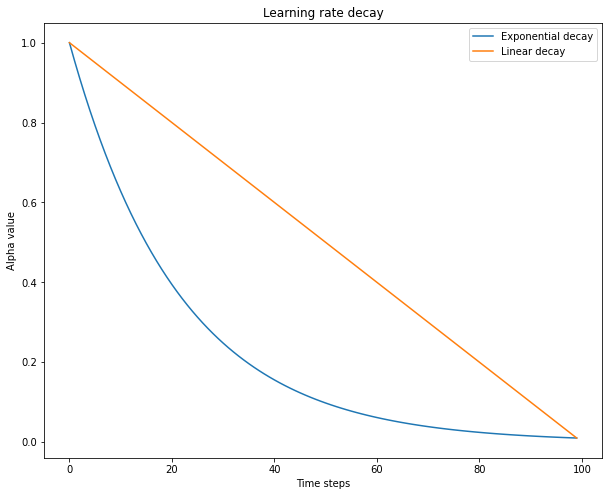

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

alpha1=decayAlpha(initialValue=1, finalValue=0.01, maxSteps=100, decayType='exponential')
alpha2=decayAlpha(initialValue=1, finalValue=0.01, maxSteps=100, decayType='linear')
plt.figure(figsize=(10,8))
plt.plot(np.arange(len(alpha1)),alpha1,label='Exponential decay')
plt.plot(np.arange(len(alpha2)),alpha2,label='Linear decay')
plt.xlabel('Time steps')
plt.ylabel('Alpha value')
plt.title('Learning rate decay')
plt.legend()
plt.show()

### Monte-Carlo Estimation

In [ ]:
def MonteCarloPrediction(env,policy,alphas,gamma=0.99,noEpisodes=500,maxSteps=1000, firstVisit=True, random=False):

  Gs=[[] for _ in range(env.observation_space.n)]
  v=[0]*env.observation_space.n
  v_r=np.zeros((noEpisodes,len(v)))
  for e in range(noEpisodes):
      t=generateTrajectory(env, policy=policy, maxSteps=maxSteps, random=random)
      alpha=alphas[e]
      visited=[0]*env.observation_space.n
      for i , (s,a,r,s_) in enumerate(t):
          if firstVisit and visited[s]:
              continue
          G=0
          for j in range(i,len(t)): 
              G+= (gamma**(j-i)) * (t[j][2])
          Gs[s].append(G) 
          v[s] += alpha * (G-v[s])
          visited[s]=1
      v_r[e]=v

  return v,v_r,Gs

(0.0, 1.0)

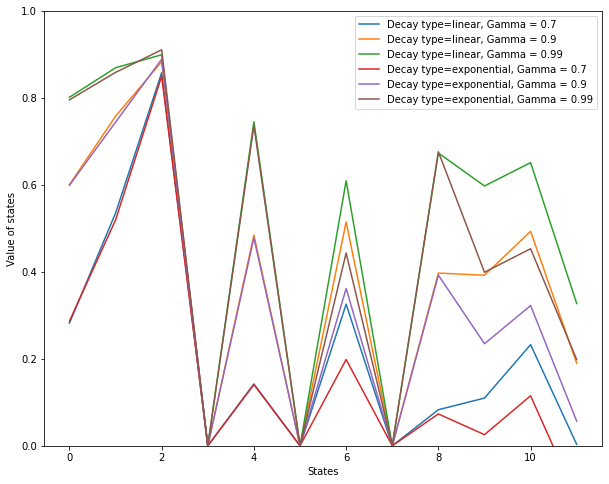

In [ ]:
noEpisodes=500
gammas=[0.7,0.9,0.99]
v_s=[]
decays=[]
decayTypes=['linear','exponential']
for decay in decayTypes:
  for g in gammas:
    alphas=decayAlpha(initialValue=1, finalValue=0.01, maxSteps=noEpisodes, decayType=decay)
    env=RME()
    env.seed()

    v,v_r,Gs=MonteCarloPrediction(env=env,policy=[3,3,3,0,0,0,0,0,0,3,0,2],alphas=alphas,gamma=g,noEpisodes=noEpisodes,maxSteps=10, firstVisit=True, random=False)
    v_s.append(v)

    decays.append(decay)

gammas=gammas*len(decayTypes)
v_s=np.array(v_s)

plt.figure(figsize=(10,8))
for i in range(len(v_s)):
  plt.plot(v_s[i],label=f'Decay type={decays[i]}, Gamma = {gammas[i]}')
plt.legend()
plt.xlabel('States')
plt.ylabel('Value of states')
plt.ylim(0,1)

(0.0, 1.0)

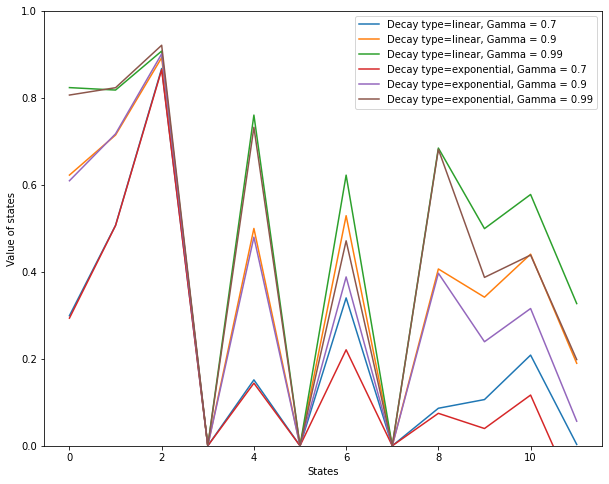

In [ ]:
noEpisodes=500
gammas=[0.7,0.9,0.99]
decays=[]
v_s=[]
decayTypes=['linear','exponential']
for decay in decayTypes:
  for g in gammas:
    alphas=decayAlpha(initialValue=1, finalValue=0.01, maxSteps=noEpisodes, decayType=decay)
    env=RME()
    env.seed()

    v,v_r,Gs=MonteCarloPrediction(env=env,policy=[3,3,3,0,0,0,0,0,0,3,0,2],alphas=alphas,gamma=g,noEpisodes=noEpisodes,maxSteps=10, firstVisit=False, random=False)
    v_s.append(v)

    decays.append(decay)

gammas=gammas*len(decayTypes)
decayTypes=[decayTypes[0]]*len(gammas) +[decayTypes[1]]*len(gammas)
v_s=np.array(v_s)

plt.figure(figsize=(10,8))
for i in range(len(v_s)):
  plt.plot(v_s[i],label=f'Decay type={decays[i]}, Gamma = {gammas[i]}')
plt.legend()
plt.xlabel('States')
plt.ylabel('Value of states')
plt.ylim(0,1)

### Temporal Difference Prediction

In [ ]:
def TemporalDifferencePrediction(env,policy,alphas,gamma=0.99,noEpisodes=500):

  v=[0]*env.observation_space.n
  v_r=np.zeros((noEpisodes,len(v)))
  td_targets=[[] for _ in range(env.observation_space.n)]

  for e in range(noEpisodes):
      alpha=alphas[e]
      s,done=env.reset()
      
      while (not done):
          a=policy[s]    
          s_, r, done, info = env.step(a)
          td_target = r  
          if not done:
              td_target += (gamma* v[s_]) 
          td_targets[s].append(td_target)
          td_error = td_target-v[s]
          v[s] += alpha * td_error
          s=s_
      v_r[e]=v

  return v,v_r,td_targets

Text(0, 0.5, 'Value of states')

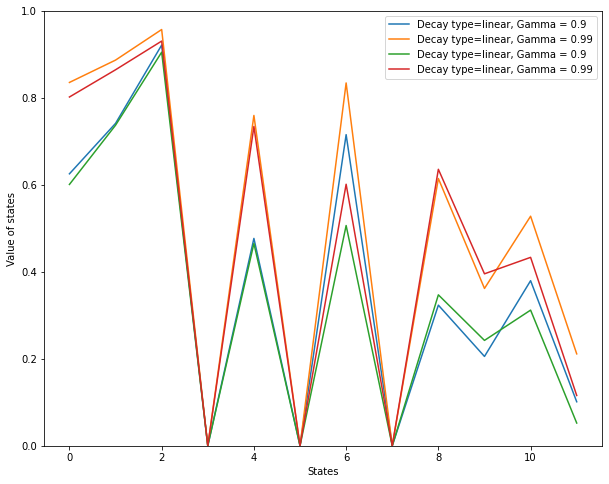

In [ ]:
noEpisodes=500
gammas=[0.9,0.99]
v_s=[]
decayTypes=['linear','exponential']
for decay in decayTypes:
  for g in gammas:
    alphas=decayAlpha(initialValue=1, finalValue=0.01, maxSteps=noEpisodes, decayType=decay)
    env=RME()
    env.seed()

    v,v_r,Gs=TemporalDifferencePrediction(env=env,policy=opt_policy,alphas=alphas,gamma=g,noEpisodes=noEpisodes)
    v_s.append(v)

gammas=gammas*len(decayTypes)
decayTypes=[decayTypes[0]]*len(gammas) +[decayTypes[1]]*len(gammas)
v_s=np.array(v_s)

plt.figure(figsize=(10,8))
for i in range(len(v_s)):
  plt.plot(v_s[i],label=f'Decay type={decayTypes[i]}, Gamma = {gammas[i]}')
plt.legend()
plt.ylim([0,1])
plt.xlabel('States')
plt.ylabel('Value of states')

### n-step TD

In [ ]:
def generateTrajectoryTD(env, s, policy, maxSteps=3):

  experiences=[]

  for e in range(maxSteps):
      a=policy[s]    
      s_, r, done, info = env.step(a)
      experiences.append([s,a,r,s_])
      if done:
        s,done=env.reset()
        return experiences,s_,done
      s=s_
  return np.array(experiences),s_,done

In [ ]:
def calculateReturnTD(t,gamma):
    returns=np.array(t)[:,2]
    gammas=[]
    for i in range(len(t)):
        gammas.append(gamma**i)
    return np.sum(returns*gammas)

In [ ]:
def nstep_TD(env,policy,alphas,n,gamma=0.99,noEpisodes=500):

  v=[0]*env.observation_space.n
  v_r=np.zeros((noEpisodes,len(v)))
  td_targets=[[] for _ in range(env.observation_space.n)]

  for e in range(noEpisodes):
      alpha=alphas[e]
      s,done=env.reset()
      
      while (not done):  
          t,s_,done=generateTrajectoryTD(env, s, policy=policy, maxSteps=n)
          g_partial=calculateReturnTD(t,gamma)
          td_target = g_partial  
          if not done:
              td_target += (gamma**n)* v[s_] 
          td_targets[s].append(td_target)
          td_error = td_target-v[s]
          v[s] += alpha * td_error
          s=s_
      v_r[e]=v

  return v,v_r,td_targets

In [ ]:
noEpisodes=500
gammas=[0.5,0.9,0.99]
v_s=[]
decayTypes=['linear','exponential']
decayTypes=['linear']
for decay in decayTypes:
  for g in gammas:
    alphas=decayAlpha(initialValue=1, finalValue=0.01, maxSteps=noEpisodes, decayType=decay)
    env=RME()
    env.seed()
    v,v_r,Gs=nstep_TD(env=env,policy=opt_policy,alphas=alphas,n=5,gamma=g,noEpisodes=noEpisodes)
    v_s.append(v)

gammas=gammas*len(decayTypes)
decayTypes=[decayTypes[0]]*len(gammas) #+[decayTypes[1]]*len(gammas)
v_s=np.array(v_s)

plt.figure(figsize=(10,8))
for i in range(len(v_s)):
  plt.plot(v_s[i],label=f'Decay type={decayTypes[i]}, Gamma = {gammas[i]}')
plt.legend()
plt.ylim([0,1])
plt.xlabel('States')
plt.ylabel('Value of states')

### TD Lambda

In [ ]:
def TDLambda(env,policy,alphas,gamma=0.99,lambd=0.3,noEpisodes=500):

  v=np.array([0]*env.observation_space.n,dtype=float)
  E=np.array([0]*env.observation_space.n,dtype=float)
  v_r=np.zeros((noEpisodes,len(v)))
  td_targets=[[] for _ in range(env.observation_space.n)]
  E_values=np.array([])

  for e in range(noEpisodes):
      alpha=alphas[e]
      s,done=env.reset()
      
      while (not done):
          a=policy[s]    
          s_, r, done, info = env.step(a)
          td_target = r  
          if not done:
              td_target += (gamma* v[s_]) 
          td_targets[s].append(td_target)
          td_error = td_target-v[s]
          E[s]+=1
          v += (alpha * td_error*E)
          E *=gamma*lambd
          s=s_
          if e==100:
            E_values=np.concatenate((E_values,E),axis=0)
      v_r[e]=v

  return v,v_r,td_targets, E_values

Text(0, 0.5, 'Value of states')

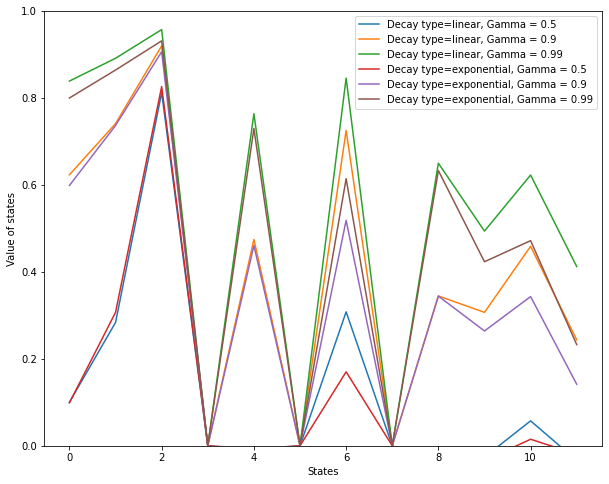

In [ ]:
noEpisodes=500
gammas=[0.5,0.9,0.99]
v_s=[]
decays=[]
decayTypes=['linear','exponential']
for decay in decayTypes:
  for g in gammas:
    alphas=decayAlpha(initialValue=1, finalValue=0.01, maxSteps=noEpisodes, decayType=decay)
    env=RME()
    env.seed()

    v,v_r,Gs,Es=TDLambda(env=env,policy=opt_policy,alphas=alphas,gamma=g,noEpisodes=noEpisodes)
    v_s.append(v)
    decays.append(decay)

gammas=gammas*len(decayTypes)
decayTypes=['linear']*len(gammas) +['exponential']*len(gammas)
v_s=np.array(v_s)

plt.figure(figsize=(10,8))
for i in range(len(v_s)):
  plt.plot(v_s[i],label=f'Decay type={decays[i]}, Gamma = {gammas[i]}')
plt.legend()
plt.ylim([0,1])
plt.xlabel('States')
plt.ylabel('Value of states')

### Averaged value approximations over time

In [ ]:
def ValueIteration(env,policy,gamma=0.99):

  s_n=env.observation_space.n #number of states
  a_n=env.action_space.n  #number of actions
  V=np.array([0.0]*s_n)
  policy=np.random.randint(s_n,size=s_n)

  for i in range(1000):
      old_V = copy.deepcopy(V)
      Q=np.array([[0.0]*a_n]*s_n)  #q values for (s,a) pairs
      for s in range(s_n):    
          for a in range(a_n):
              temp = 0
              for j in range(s_n):
                  if((s,a,j) in transition_prob):
                      temp+= transition_prob[s,a,j]*(R[j] + gamma*old_V[j])
              Q[s][a] = temp  
          V[s] = max(Q[s])
      
      policy=np.argmax(Q,axis=1)
      
      if sum(abs(V-old_V)) <= 10**(-10):
          return V,policy,i
          
  return V,policy,i

In [ ]:
env=RME()
s,done=env.reset()
env.seed()
opt_V,opt_policy,i=ValueIteration(env=env,policy=policy)
print(f'''The optimal values for the states obtained from the algorithm in {i} iterations is:
 {opt_V}.''')

The optimal values for the states obtained from the algorithm in 28 iterations is:
 [0.50822459 0.64083803 0.84954296 0.         0.37051388 0.
 0.54083803 0.         0.28888143 0.31751957 0.44131259 0.21751957].


#### MC-FVMC

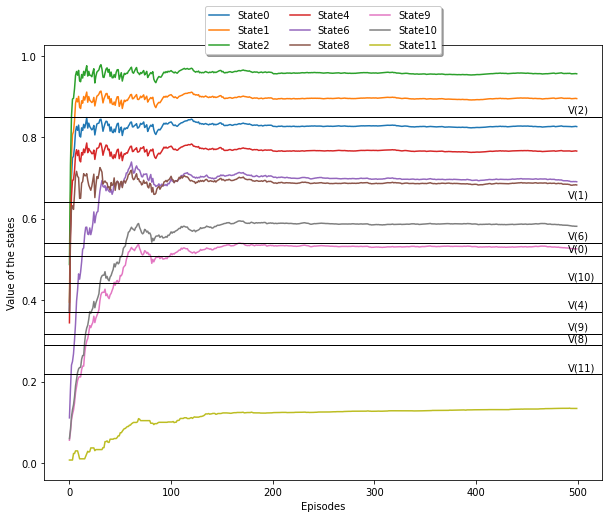

seeds:[17 33 76  3 56  0 37  8 60 67 36  7 59 73 34 74 43 47 80  2 14 15 20 39
 22 69 78 38 19 63 21 79 30 45 97 91  4  9 85 53  5 29 50 64 68 66 26 83
 88 35]


In [ ]:
np.random.seed(31)
seeds=np.random.choice(100,size=50,replace=False)
noEpisodes=500
alphas=np.append(decayAlpha(initialValue=0.5, finalValue=0.01, maxSteps=int(noEpisodes/2), decayType='exponential'),[0.01]*int(noEpisodes/2))
total_v_r=[]
for seed in seeds:
  env=RME()
  env.seed(seed)
  v,v_r,td_targets=v,v_r,Gs=MonteCarloPrediction(env=env,policy=opt_policy,alphas=alphas,noEpisodes=noEpisodes, maxSteps=1000,firstVisit=True)
  total_v_r.append(v_r)

v_r=np.mean(total_v_r, axis=0)

plt.figure(figsize=(10,8))
for i in range(v_r.shape[1]):
  if i==3 or i==7 or i==5:  #terminal and wall states
    continue
  plt.plot(np.arange(v_r.shape[0]),v_r[:,i],label=f'State{i}')

for i in range(len(opt_V)):
  trueValue=opt_V[i]
  if trueValue==0:
    continue
  plt.axhline(y=trueValue, color='black', linestyle='-',linewidth=1)
  plt.text(v_r.shape[0]-10,trueValue+0.01,f'V({i})')

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1),
          ncol=3, fancybox=True, shadow=True)
plt.xlabel('Episodes')
plt.ylabel('Value of the states')
plt.show()

print(f'seeds:{seeds}')

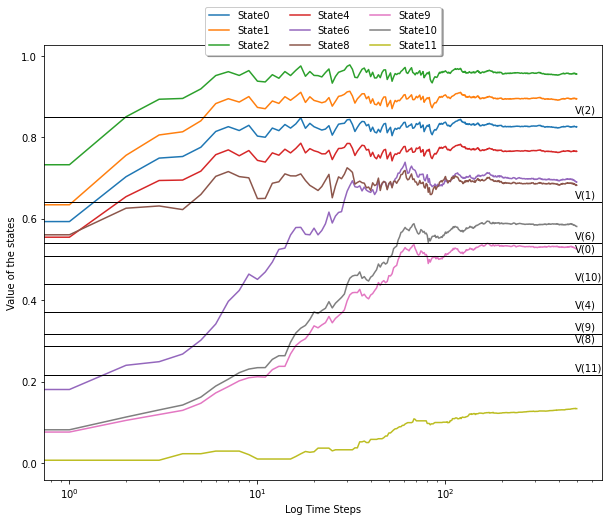

In [ ]:
plt.figure(figsize=(10,8))
for i in range(v_r.shape[1]):
  if i==3 or i==7 or i==5:  #terminal and wall states
    continue
  plt.plot(np.arange(v_r.shape[0]),v_r[:,i],label=f'State{i}')

for i in range(len(opt_V)):
  trueValue=opt_V[i]
  if trueValue==0:
    continue
  plt.axhline(y=trueValue, color='black', linestyle='-',linewidth=1)
  plt.text(v_r.shape[0]-10,trueValue+0.01,f'V({i})')

plt.xscale('log')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1),
          ncol=3, fancybox=True, shadow=True)
plt.xlabel('Log Time Steps')
plt.ylabel('Value of the states')
plt.show()

#### MC-EVMC

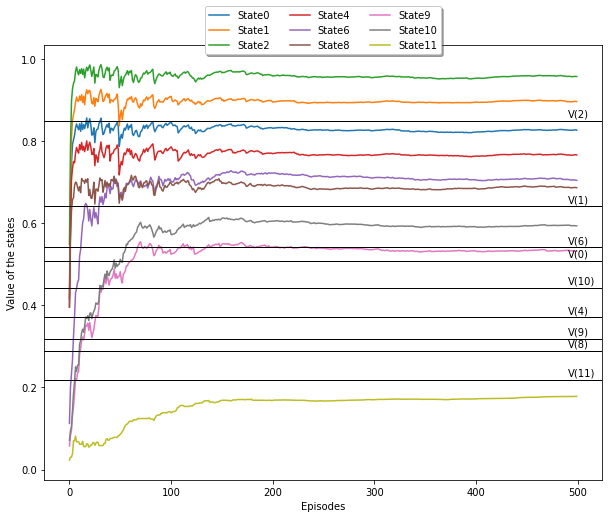

seeds:[22 43 88  4 55 96 83 85 54  6 24 31 36 56 57 26 16 37 64 74 66 46 67 91
 99 77 39 17 75 53 73 79 30 12 95 44 11 38 60 48 70 34 98 14 97  7 65 19
 28 25]


In [ ]:
seeds=np.random.choice(100,size=50,replace=False)
noEpisodes=500
alphas=np.append(decayAlpha(initialValue=0.5, finalValue=0.01, maxSteps=int(noEpisodes/2), decayType='exponential'),[0.01]*int(noEpisodes/2))
total_v_r=[]
for seed in seeds:
  env=RME()
  env.seed(seed)
  v,v_r,td_targets=v,v_r,Gs=MonteCarloPrediction(env=env,policy=opt_policy,alphas=alphas,noEpisodes=noEpisodes, maxSteps=1000,firstVisit=False)
  total_v_r.append(v_r)

v_r=np.mean(total_v_r, axis=0)

plt.figure(figsize=(10,8))
for i in range(v_r.shape[1]):
  if i==3 or i==7 or i==5:  #terminal and wall states
    continue
  plt.plot(np.arange(v_r.shape[0]),v_r[:,i],label=f'State{i}')

for i in range(len(opt_V)):
  trueValue=opt_V[i]
  if trueValue==0:
    continue
  plt.axhline(y=trueValue, color='black', linestyle='-',linewidth=1)
  plt.text(v_r.shape[0]-10,trueValue+0.01,f'V({i})')

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1),
          ncol=3, fancybox=True, shadow=True)
plt.xlabel('Episodes')
plt.ylabel('Value of the states')
plt.show()

print(f'seeds:{seeds}')

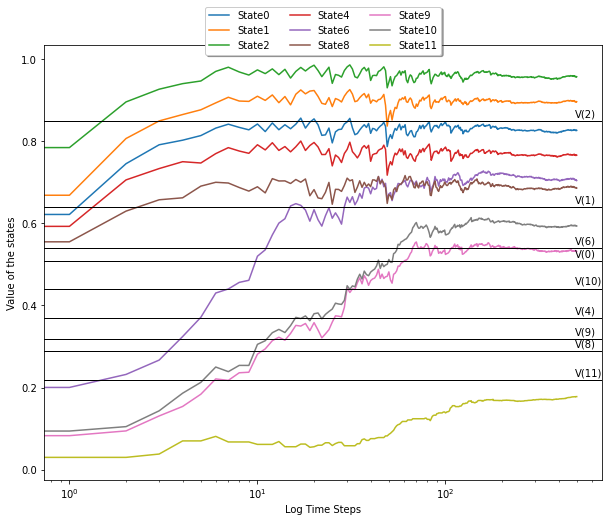

In [ ]:
plt.figure(figsize=(10,8))
for i in range(v_r.shape[1]):
  if i==3 or i==7 or i==5:  #terminal and wall states
    continue
  plt.plot(np.arange(v_r.shape[0]),v_r[:,i],label=f'State{i}')

for i in range(len(opt_V)):
  trueValue=opt_V[i]
  if trueValue==0:
    continue
  plt.axhline(y=trueValue, color='black', linestyle='-',linewidth=1)
  plt.text(v_r.shape[0]-10,trueValue+0.01,f'V({i})')

plt.xscale('log')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1),
          ncol=3, fancybox=True, shadow=True)
plt.xlabel('Log Time Steps')
plt.ylabel('Value of the states')
plt.show()

#### TD

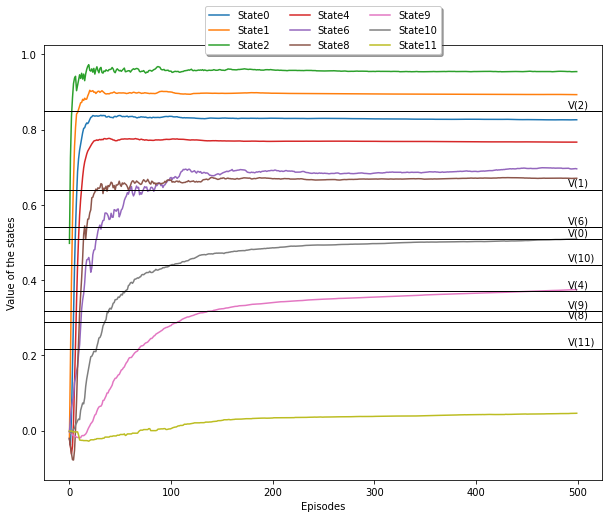

In [ ]:
seeds=np.random.choice(100,size=50,replace=False)
noEpisodes=500
alphas=np.append(decayAlpha(initialValue=0.5, finalValue=0.01, maxSteps=int(noEpisodes/2), decayType='exponential'),[0.01]*int(noEpisodes/2))
total_v_r=[]
for seed in seeds:
  env=RME()
  env.seed(seed)
  v,v_r,td_targets=TemporalDifferencePrediction(env=env,policy=opt_policy,alphas=alphas,noEpisodes=noEpisodes)
  total_v_r.append(v_r)

v_r=np.mean(total_v_r, axis=0)

plt.figure(figsize=(10,8))
for i in range(v_r.shape[1]):
  if i==3 or i==7 or i==5:  #terminal and wall states
    continue
  plt.plot(np.arange(v_r.shape[0]),v_r[:,i],label=f'State{i}')

for i in range(len(opt_V)):
  trueValue=opt_V[i]
  if trueValue==0:
    continue
  plt.axhline(y=trueValue, color='black', linestyle='-',linewidth=1)
  plt.text(490,trueValue+0.01,f'V({i})')

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1),
          ncol=3, fancybox=True, shadow=True)
plt.xlabel('Episodes')
plt.ylabel('Value of the states')
plt.show()

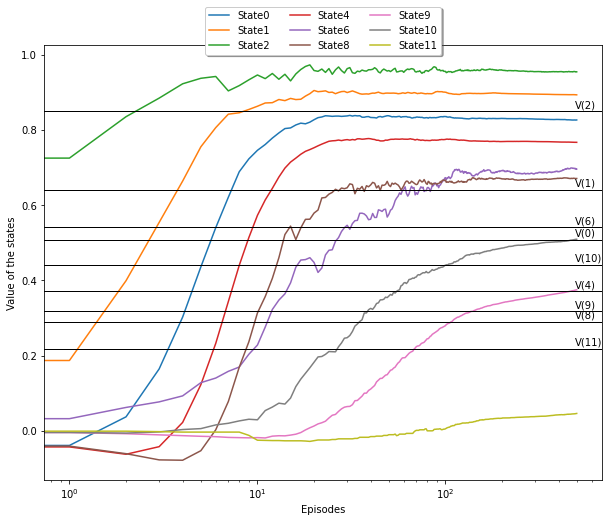

In [ ]:
plt.figure(figsize=(10,8))
for i in range(v_r.shape[1]):
  if i==3 or i==7 or i==5:  #terminal and wall states
    continue
  plt.plot(np.arange(v_r.shape[0]),v_r[:,i],label=f'State{i}')

for i in range(len(opt_V)):
  trueValue=opt_V[i]
  if trueValue==0:
    continue
  plt.axhline(y=trueValue, color='black', linestyle='-',linewidth=1)
  plt.text(490,trueValue+0.01,f'V({i})')

plt.xscale('log')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1),
          ncol=3, fancybox=True, shadow=True)
plt.xlabel('Episodes')
plt.ylabel('Value of the states')
plt.show()

#### TD (lambda)

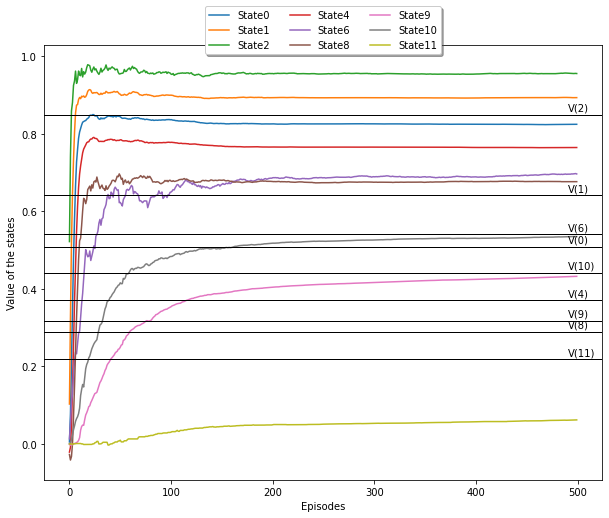

In [ ]:
seeds=np.random.choice(100,size=50,replace=False)
noEpisodes=500
alphas=np.append(decayAlpha(initialValue=0.5, finalValue=0.01, maxSteps=int(noEpisodes/2), decayType='exponential'),[0.01]*int(noEpisodes/2))
total_v_r=[]
for seed in seeds:
  env=RME()
  env.seed(seed)
  v,v_r,td_targets,Es=TDLambda(env=env,policy=opt_policy,alphas=alphas,noEpisodes=noEpisodes)
  total_v_r.append(v_r)

v_r=np.mean(total_v_r, axis=0)

plt.figure(figsize=(10,8))
for i in range(v_r.shape[1]):
  if i==3 or i==7 or i==5:  #terminal and wall states
    continue
  plt.plot(np.arange(v_r.shape[0]),v_r[:,i],label=f'State{i}')

for i in range(len(opt_V)):
  trueValue=opt_V[i]
  if trueValue==0:
    continue
  plt.axhline(y=trueValue, color='black', linestyle='-',linewidth=1)
  plt.text(490,trueValue+0.01,f'V({i})')

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1),
          ncol=3, fancybox=True, shadow=True)
plt.xlabel('Episodes')
plt.ylabel('Value of the states')
plt.show()

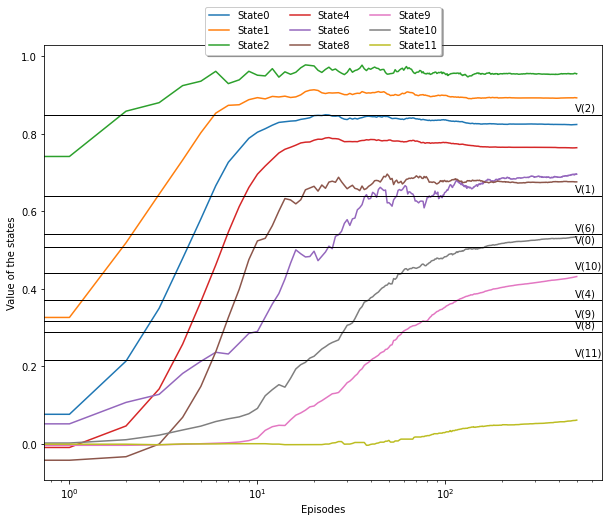

In [ ]:
plt.figure(figsize=(10,8))
for i in range(v_r.shape[1]):
  if i==3 or i==7 or i==5:  #terminal and wall states
    continue
  plt.plot(np.arange(v_r.shape[0]),v_r[:,i],label=f'State{i}')

for i in range(len(opt_V)):
  trueValue=opt_V[i]
  if trueValue==0:
    continue
  plt.axhline(y=trueValue, color='black', linestyle='-',linewidth=1)
  plt.text(490,trueValue+0.01,f'V({i})')

plt.xscale('log')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1),
          ncol=3, fancybox=True, shadow=True)
plt.xlabel('Episodes')
plt.ylabel('Value of the states')
plt.show()

In [ ]:
noEpisodes=500
alphas=np.append(decayAlpha(initialValue=0.5, finalValue=0.01, maxSteps=int(noEpisodes/2), decayType='exponential'),[0.01]*int(noEpisodes/2))
env=RME()
env.seed(42)
v,v_r,td_targets,Es=TDLambda(env=env,policy=opt_policy,alphas=alphas,noEpisodes=noEpisodes)

Text(0, 0.5, 'Eligibilty trace value')

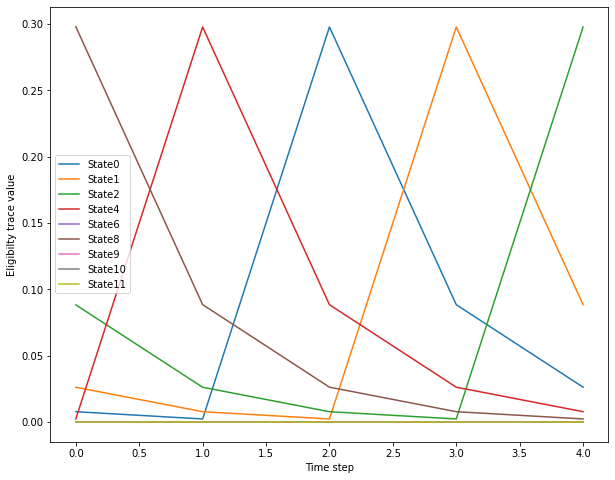

In [ ]:
plt.figure(figsize=(10,8))
Es=Es.reshape(int(Es.shape[0]/12),12)
for i in range(Es.shape[1]):
  if i==3 or i==7 or i==5:  #terminal and wall states
    continue
  plt.plot(np.arange(Es.shape[0]),Es[:,i],label=f'State{i}')
plt.legend()
plt.xlabel('Time step')
plt.ylabel('Eligibilty trace value')

### Target Sequence

#### MC-FVMC

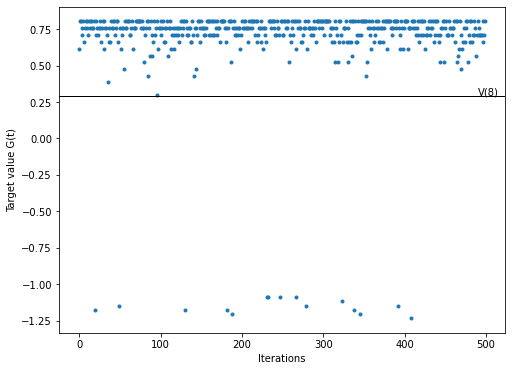

In [ ]:
env=RME()
env.seed()
noEpisodes=500
alphas=np.append(decayAlpha(initialValue=0.5, finalValue=0.01, maxSteps=int(noEpisodes/2), decayType='exponential'),[0.01]*int(noEpisodes/2))
v,v_r,Gs=MonteCarloPrediction(env=env,policy=opt_policy,alphas=alphas,firstVisit=True)

s=8
plt.figure(figsize=(8,6))
plt.plot(np.arange(len(Gs[s])),Gs[s],'.')
plt.axhline(y=opt_V[s], color='black', linestyle='-',linewidth=1)
plt.text(len(Gs[s])-10,opt_V[s]+0.01,f'V({s})')
plt.xlabel('Iterations')
plt.ylabel('Target value G(t)')
plt.show()

#### MC-EVMC

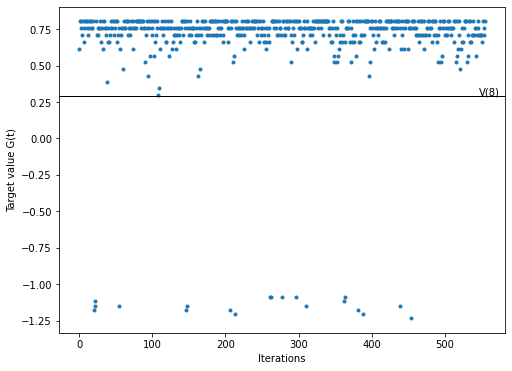

In [ ]:
env=RME()
env.seed()
noEpisodes=500
alphas=np.append(decayAlpha(initialValue=0.5, finalValue=0.01, maxSteps=int(noEpisodes/2), decayType='exponential'),[0.01]*int(noEpisodes/2))
v,v_r,Gs=MonteCarloPrediction(env=env,policy=opt_policy,alphas=alphas,firstVisit=False)

s=8
plt.figure(figsize=(8,6))
plt.plot(np.arange(len(Gs[s])),Gs[s],'.')
plt.axhline(y=opt_V[s], color='black', linestyle='-',linewidth=1)
plt.text(len(Gs[s])-10,opt_V[s]+0.01,f'V({s})')
plt.xlabel('Iterations')
plt.ylabel('Target value G(t)')
plt.show()

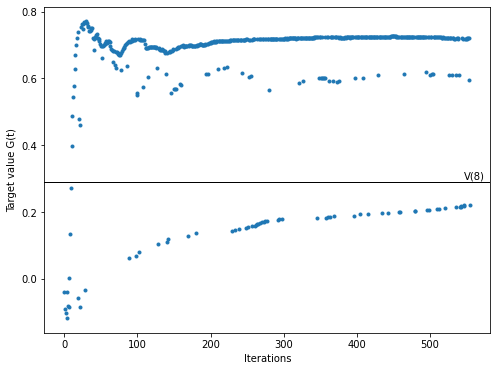

In [ ]:
env=RME()
env.seed()
noEpisodes=500
alphas=np.append(decayAlpha(initialValue=0.5, finalValue=0.01, maxSteps=int(noEpisodes/2), decayType='exponential'),[0.01]*int(noEpisodes/2))
v,v_r,Gs=TemporalDifferencePrediction(env=env,policy=opt_policy,alphas=alphas)

s=8
plt.figure(figsize=(8,6))
plt.plot(np.arange(len(Gs[s])),Gs[s],'.')
plt.axhline(y=opt_V[s], color='black', linestyle='-',linewidth=1)
plt.text(len(Gs[s])-10,opt_V[s]+0.01,f'V({s})')
plt.xlabel('Iterations')
plt.ylabel('Target value G(t)')
plt.show()

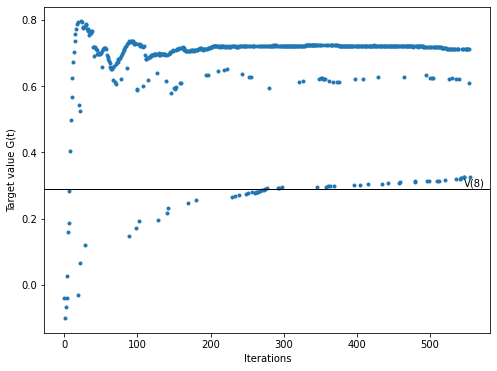

In [ ]:
env=RME()
env.seed()
noEpisodes=500
alphas=np.append(decayAlpha(initialValue=0.5, finalValue=0.01, maxSteps=int(noEpisodes/2), decayType='exponential'),[0.01]*int(noEpisodes/2))
v,v_r,Gs,Es=TDLambda(env=env,policy=opt_policy,alphas=alphas)

s=8
plt.figure(figsize=(8,6))
plt.plot(np.arange(len(Gs[s])),Gs[s],'.')
plt.axhline(y=opt_V[s], color='black', linestyle='-',linewidth=1)
plt.text(len(Gs[s])-10,opt_V[s]+0.01,f'V({s})')
plt.xlabel('Iterations')
plt.ylabel('Target value G(t)')
plt.show()